In [1]:
#http://www.nlpr.ia.ac.cn/databases/handwriting/Download.html
%matplotlib inline
import matplotlib.pylab as pylab

In [2]:
#Let's import the WAV file!
from scipy.io import wavfile

In [83]:
waveform_directory = 'data/simple'

In [98]:
import re
import os
import collections
def import_samples(directory):
    filenames = os.listdir(directory)
    filenames_by_syllable = collections.defaultdict(dict)
    for filename in filenames:
        match = re.match(r'^(\w+)(\d)\.wav$', filename)
        if match:
            filenames_by_syllable[match.group(1).lower()][int(match.group(2))] = os.path.join(directory,filename)
    return filenames_by_syllable

filenames_by_syllable = import_samples(waveform_directory)

In [99]:
example = wavfile.read(filenames_by_syllable['ma'][1])

/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


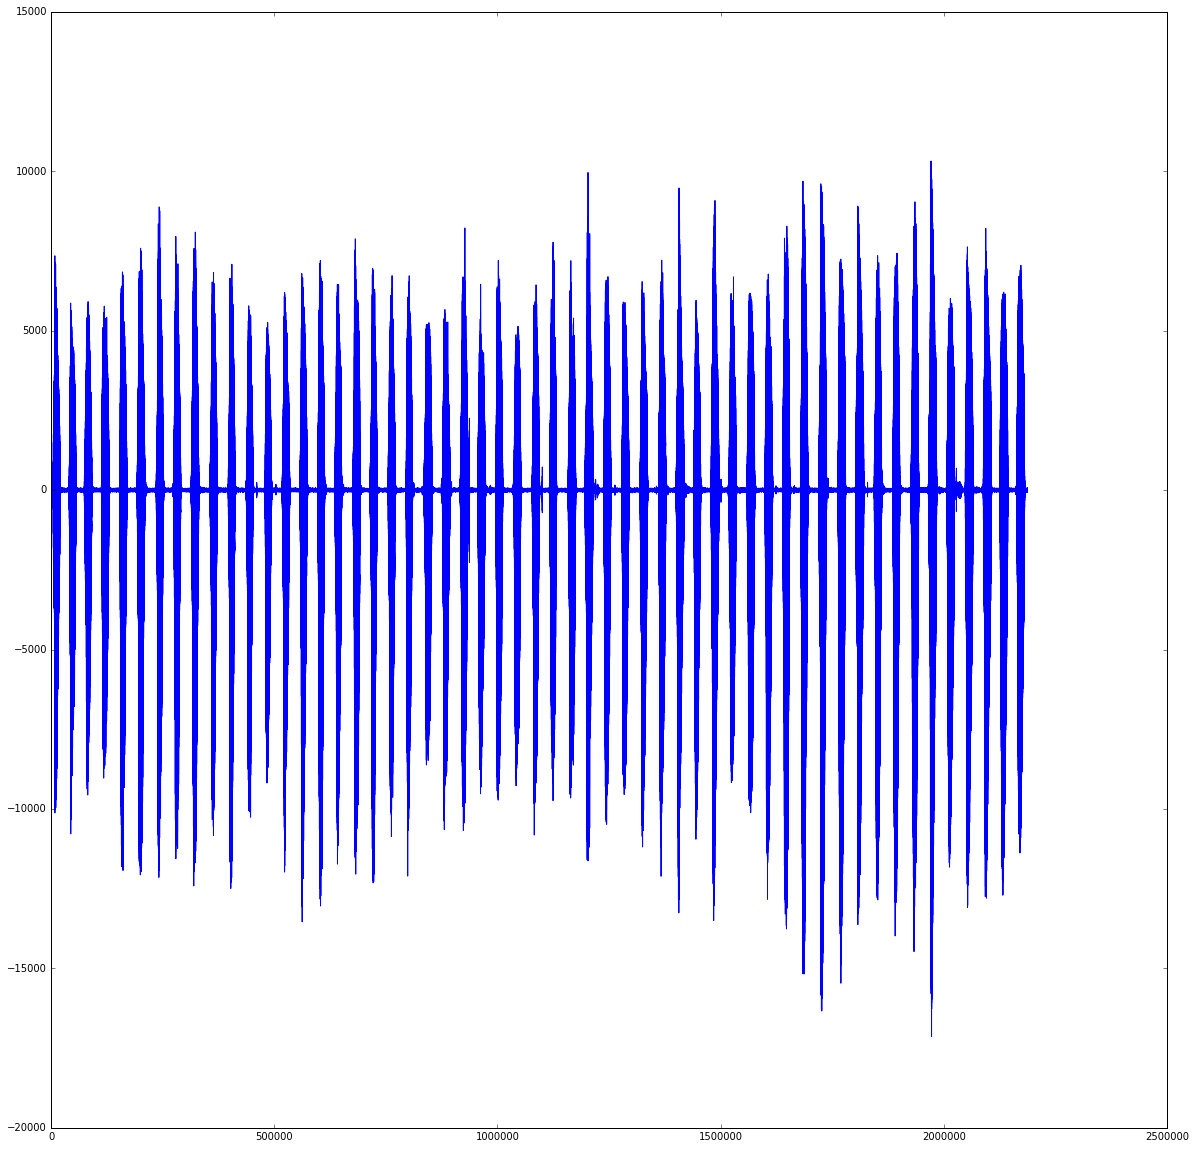

In [100]:
import numpy as np
rate = example[0]
t = 50.4
pylab.figure(figsize=(20,20))

segment = example[1][rate*0.8:rate*t]
N=1
smooth_power = np.convolve(segment.astype(np.float64), np.ones((N,))/N, mode='valid')

pylab.plot(smooth_power)
import IPython
IPython.display.Audio(example[1][rate*0.8:rate*t],rate=example[0])

In [101]:
def from_window_coordinates(x, window, overlap):
    di = window-overlap
    return x*di

def to_window_coordinates(x, window, overlap):
    di = window-overlap
    return x//di

def get_power_envelope(signal, window,overlap=None):
    if overlap is None:
        overlap = window // 2
    i = 0
    di = window-overlap
    n = len(signal) // di
    output = np.zeros((len(signal)//di,),dtype=np.float64)
    hamming_window = np.hamming(window)
    while i < n-1:
        frame = signal[i*di:i*di+window]*hamming_window
        fft = np.fft.rfft(frame)
        output[i] = np.sum((fft*np.conjugate(fft)).astype(np.float64))
        i+=1
    return output

def get_entropy(signal, window,overlap=None):
    if overlap is None:
        overlap = window // 2
    i = 0
    di = window-overlap
    n = len(signal) // di
    output = np.zeros((len(signal)//di,),dtype=np.float64)
    hamming_window = np.hamming(window)
    while i < n-1:
        frame = signal[i*di:i*di+window]*hamming_window
        fft = np.fft.rfft(frame)
        power_spectrum = (fft*np.conjugate(fft)).astype(np.float64)
        #power_spectrum[:float(window)/5] = 0
        #power_spectrum[float(window)*4./5.:] = 0
        total_power = np.sum(power_spectrum)
        probability = power_spectrum/total_power
        entropy = 0
        for p in probability:
            if p > 0:
                entropy-=p*np.log(p)
        output[i] = entropy*np.sqrt(total_power)
        i+=1
    return output

def get_frequency_spectrum(signal, window, overlap=None):
    if overlap is None:
        overlap = window // 2
    i = 0
    di = window-overlap
    n = len(signal) // di
    output = np.zeros((window/2+1,len(signal)//di),dtype=np.float64)
    hamming_window = np.hamming(window)
    while i < n-1:
        frame = signal[i*di:i*di+window]*hamming_window
        fft = np.fft.rfft(frame)
        output[:,i] = ((fft*np.conjugate(fft)).astype(np.float64))
        i+=1
    return output


/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


(0, 13380)

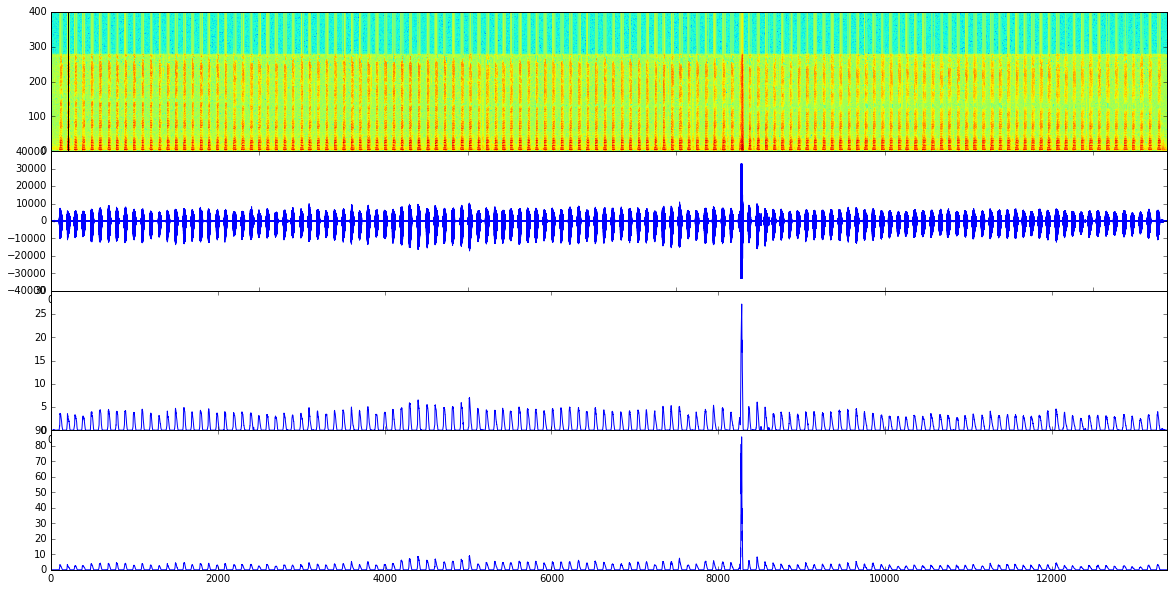

In [102]:
W = 800
O = 400
frequency_spectrum = get_frequency_spectrum(example[1], window=W, overlap=O)
envelope = get_power_envelope(example[1], window=W, overlap=O)
envelope = envelope/np.mean(envelope)
dominant_frequency = np.argmax(frequency_spectrum,0)
entropy = get_entropy(example[1],window=W, overlap=O)
entropy = entropy/np.mean(entropy)

fig=pylab.figure(figsize=(20,10))
pylab.subplot(411)
plot=pylab.imshow(np.log(frequency_spectrum),aspect='auto',origin='lowerleft')
plot.axes.get_xaxis().set_visible(False)
pylab.axvline(200,ls='-',color='black')
fig.subplots_adjust(hspace=0)

pylab.subplot(412)
pylab.plot(example[1])
pylab.xlim(0,len(example[1]))

pylab.subplot(413)
pylab.plot(entropy)
#pylab.semilogy()
pylab.xlim(0,len(dominant_frequency))

pylab.subplot(414)
#pylab.semilogy()
pylab.plot()
pylab.plot(envelope)
pylab.xlim(0,len(envelope))
#plot.axes.get_xaxis().set_visible(False)


(0, 2000)

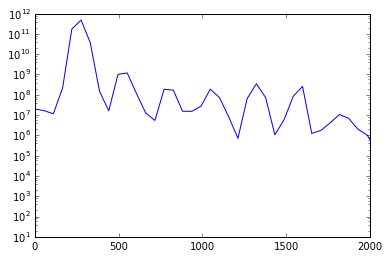

In [158]:
frequencies = np.linspace(0,rate/2.0,frequency_spectrum.shape[0])
pylab.plot(frequencies,frequency_spectrum[:,10])
pylab.semilogy()
pylab.xlim(0,2000)

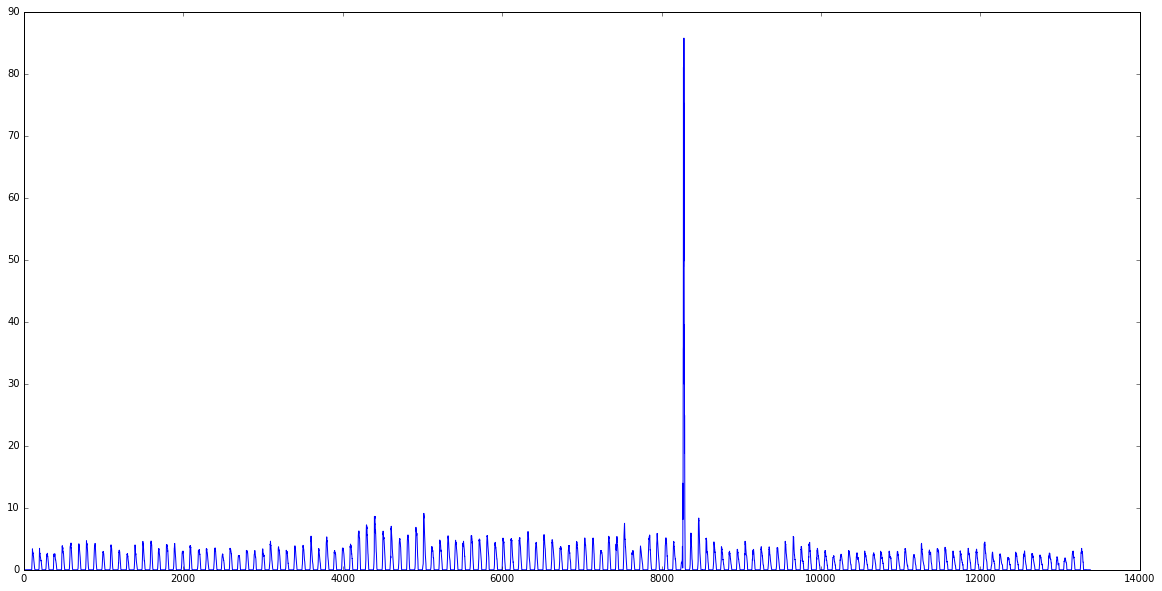

In [104]:
def smooth_signal(signal, steps):
    smoothed_signal = np.array(signal.shape,dtype=signal.dtype)
    smoother = np.exp((-(np.linspace(-1,1,2*steps+1) )))
    smoother/=np.sum(smoother)
    return np.convolve(signal,smoother,'same')
pylab.figure(figsize=(20,10))
se = smooth_signal(envelope,3)
#pylab.plot(se[1:]-se[:-1])
pylab.plot(envelope)

In [105]:
def get_window(signal,threshold_up=0.1,threshold_down=0.2):
    i = 0
    
    once_under_threshold = False
    while i < len(signal):
        if signal[i] <= threshold_up:
            once_under_threshold = True
        if once_under_threshold and signal[i] > threshold_up:
            break
        i+=1
    start = i
    once_over_threshold = False
    while i < len(signal):
        if signal[i] >= threshold_down:
            once_over_threshold = True
        if once_over_threshold and signal[i] < threshold_down:
            break
        i+=1
    return start,i

In [106]:
def extract_syllables(envelope):
    syllables = []
    start = 0
    while start < len(envelope):
        new_start, stop = get_window(envelope[start:], threshold_up=0.5, threshold_down=0.4)
        if new_start == start:
            start+=1
            continue
        syllables.append((start+new_start,start+stop))
        if stop == 0:
            stop = 1
        start+= new_start+stop
    return syllables

In [107]:
syllable_windows=extract_syllables(smooth_signal(envelope,1))

In [108]:
print len(syllable_windows)

113


In [302]:
start, stop = syllable_windows[56]
print start, stop
IPython.display.Audio(example[1][from_window_coordinates(max(0,start-5),W,O):from_window_coordinates(stop+4,W,O)],rate=rate)

5801 5837




# Mel frequency coefficients

The Mel scale [1] defines a series of frequencies that, when played, are perceived as equally "distant" by people. The scale is measured in "mels", and a value of 1000 is assigned to the 1000 Hz frequency.

To convert from frequency to mel, we can use the following function[2]:

$$ m=2595\cdot \log_{10}{\left(1+\frac{f}{700}\right)}$$

[1]: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
[2]: https://en.wikipedia.org/wiki/Mel_scale

In [195]:
def get_mels_from_frequencies(frequencies):
    return 2595.*np.log10(1.0+frequencies/700.0)

def get_frequencies_from_mels(mels):
    return (np.exp(np.log(10)*mels/2595.)-1.0)*700.0

fs = np.array([100,1000,2000,4000,8000])

print get_mels_from_frequencies(fs)

#applying the reverse transform should give us the same frequencies again (up to a numerical error)
np.testing.assert_allclose(get_frequencies_from_mels(get_mels_from_frequencies(fs)),fs)

[  150.48910241   999.98553714  1521.35955416  2146.06452751  2840.02304671]


Now, to generate a Mel spectrum from a given audio segment, we can follow this recipe:

* Take the Fourier transform of (a windowed excerpt of) a signal.
* Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
* Take the logs of the powers at each of the mel frequencies.
* Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
* The MFCCs are the amplitudes of the resulting spectrum.

Let's implement this!

In [196]:
#There are different mel scales proposed for speech recognition

#this one is the original one, from 1949 :O
beranek_mel_scale = (0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250)

#this one is more modern, from 1999
umesh_mel_scale = (43,257,300,514,771,928,1000,1542,2000,2142,2314,2600,2771,2914,3228)

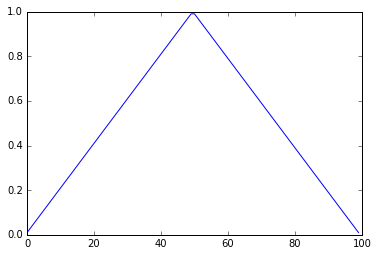

In [197]:
#now, we want to get a filter bank with some overlap, so let's choose 50 %
import scipy.signal

#this is a triangle function
pylab.plot(scipy.signal.triang(100))

/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


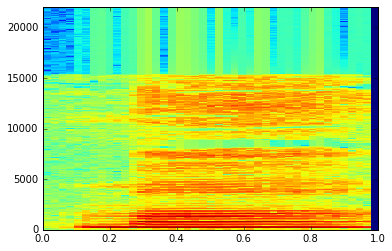

In [198]:
#we take the first utterance from our samples
start, stop = syllable_windows[0]
sample = example[1][from_window_coordinates(max(0,start-5),W,O):from_window_coordinates(stop+4,W,O)]

frequency_spectrum = get_frequency_spectrum(sample, W, O)
pylab.imshow(np.log(frequency_spectrum+0.001),aspect='auto', interpolation='nearest',extent=(0,1,0,rate/2.0),origin='lowerleft')

(0, 2000)

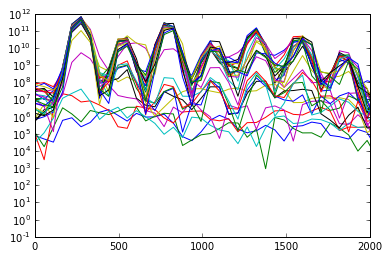

In [206]:
max_frequency = rate/2.0
n_bins = frequency_spectrum.shape[0]
frequencies = np.linspace(0,max_frequency,n_bins)
for i in range(30):
    pylab.plot(frequencies, frequency_spectrum[:,i])
pylab.semilogy()
pylab.xlim(0,2000)

In [234]:
frequency_filters = []
overlap = 0.5

mel_scale = beranek_mel_scale

for i,mel in enumerate(mel_scale):
    if i < len(mel_scale)-1:
        width = mel_scale[i+1]-mel
    else:
        width = mel-mel_scale[i-1]
    start_frequency = get_frequencies_from_mels(mel-width*2*overlap)
    stop_frequency = get_frequencies_from_mels(mel+width*2*overlap)
    
    filter_coefficients = np.zeros(n_bins)
    
    start_n = max(0,int(start_frequency/max_frequency*n_bins))
    stop_n = min(n_bins-1,int(stop_frequency/max_frequency*n_bins))
 
    if (stop_n-start_n) % 2 == 0:
        stop_n +=1
 
    filter_coefficients[start_n:stop_n] = scipy.signal.triang(stop_n-start_n)
    frequency_filters.append(filter_coefficients)

(0, 5000)

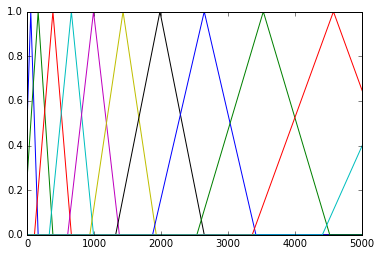

In [235]:
for frequency_filter in frequency_filters:
    pylab.plot(frequencies,frequency_filter)

pylab.xlim(0,5000)

In [236]:
def get_filtered_power_spectrum(spectrum, frequency_filters):
    
    power_spectrum = np.zeros(len(frequency_filters))
    for i,frequency_filter in enumerate(frequency_filters):
        power_spectrum[i] = np.sum(frequency_filter*spectrum)
    return power_spectrum

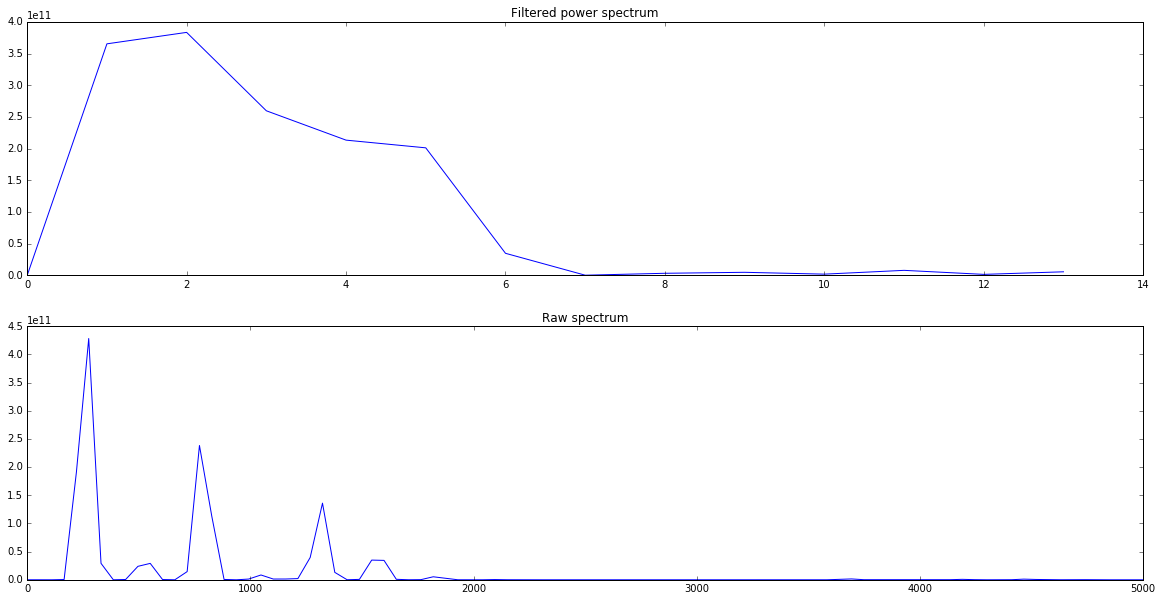

In [256]:
filtered_power_spectrum = get_filtered_power_spectrum(frequency_spectrum[:,20], frequency_filters)

pylab.figure(figsize=(20,10))
pylab.subplot(211)
pylab.plot(filtered_power_spectrum)
pylab.title("Filtered power spectrum")
pylab.subplot(212)
pylab.plot(frequencies,frequency_spectrum[:,20])
pylab.xlim(0,5000)
pylab.title("Raw spectrum")

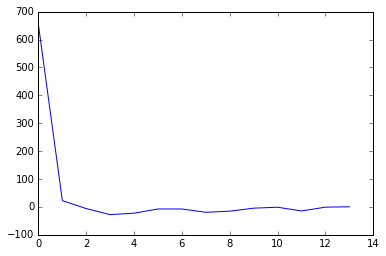

In [480]:
#http://dsp.stackexchange.com/questions/31/how-do-i-interpret-the-dct-step-in-the-mfcc-extraction-process
import scipy.fftpack

def get_mel_coefficients(filtered_power_spectrum):
    return scipy.fftpack.dct(np.log(np.abs(filtered_power_spectrum)+0.01))

mel_coefficients = get_mel_coefficients(filtered_power_spectrum)
pylab.plot(mel_coefficients)

Now that we have the Mel coefficients, we still need a way to convert a syllable into a feature vector with a fixed length that we can pass to our machine learning system.

To do this, we will split the syllable into four different parts from beginning to end. For each part, we will calculate the average Mel spectrum for the given part of the utterance.

Like that, we can make our algorithm somewhat robust against different speaking speeds.

In [835]:
def get_mel_coefficients_for_sample(sample, frequency_filters):
    #first, we calculate the frequency spectrum
    frequency_spectrum = get_frequency_spectrum(sample, W, O)
    mel_coefficients = np.zeros((len(frequency_filters),frequency_spectrum.shape[1]))
    for i in range(frequency_spectrum.shape[1]):
        filtered_power_spectrum = get_filtered_power_spectrum(frequency_spectrum[:,i], frequency_filters)
        mel_coefficients[:,i] = np.log(np.abs(filtered_power_spectrum)+0.01)#get_mel_coefficients(filtered_power_spectrum)
    #then, we iterate
    return mel_coefficients

/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


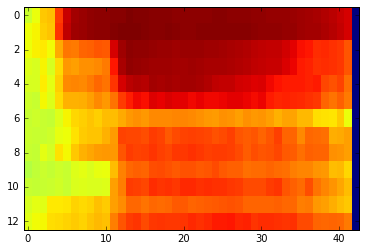

In [836]:
sample_mel_coefficients = get_mel_coefficients_for_sample(sample, frequency_filters)
pylab.imshow(sample_mel_coefficients[1:,:],aspect='auto', interpolation='nearest')

In [837]:
def get_feature_vector_from_mel_coefficients(mel_coefficients, n=4):
    l = mel_coefficients.shape[1]
    n_mel = mel_coefficients.shape[0]
    #might not match in all cases, but here we ignore it...
    di = max(2,l/n)
    feature_vector = np.zeros(n*n_mel)
    for i in range(n):
        if i*di >= l:
            continue
        coeffs = mel_coefficients[:,i*di:(i+1)*di]
        means = np.mean(coeffs,axis=1)
        feature_vector[n_mel*i:n_mel*(i+1)] = means
    return feature_vector

(56,)


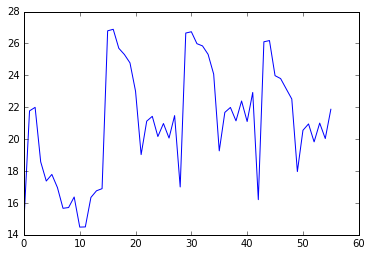

In [838]:
feature_vector = get_feature_vector_from_mel_coefficients(sample_mel_coefficients)
pylab.plot(feature_vector)
print feature_vector.shape

In [928]:
def get_feature_vectors_for_syllable_and_tone(syllable, tone, n=4):
    return get_feature_vectors_for_file(filenames_by_syllable[syllable][tone])
    
def get_feature_vectors_for_file(filename, n=4):
    rate, sample = wavfile.read(filename)
    envelope = get_power_envelope(sample, window=W, overlap=O)
    envelope = envelope/np.mean(envelope)
    syllable_windows=extract_syllables(smooth_signal(envelope,1))
    feature_vectors = []

    for start,stop in syllable_windows:
        syllable_sample = sample[from_window_coordinates(max(0,start-5),W,O):from_window_coordinates(stop+4,W,O)]
        sample_mel_coefficients = get_mel_coefficients_for_sample(syllable_sample, frequency_filters)
        sample_feature_vector = get_feature_vector_from_mel_coefficients(sample_mel_coefficients, n=n)
        feature_vectors.append(sample_feature_vector)

    return np.array(feature_vectors)

In [840]:
feature_vectors = collections.defaultdict(dict)

for syllable, tones in filenames_by_syllable.items():
    for tone in tones:
        feature_vectors[syllable][tone] = get_feature_vectors_for_syllable_and_tone(syllable, tone, n=1)

/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/home/andreas/projects/python/chinese/venv/lib/python2.7/site-packages/ipykernel/__main__.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


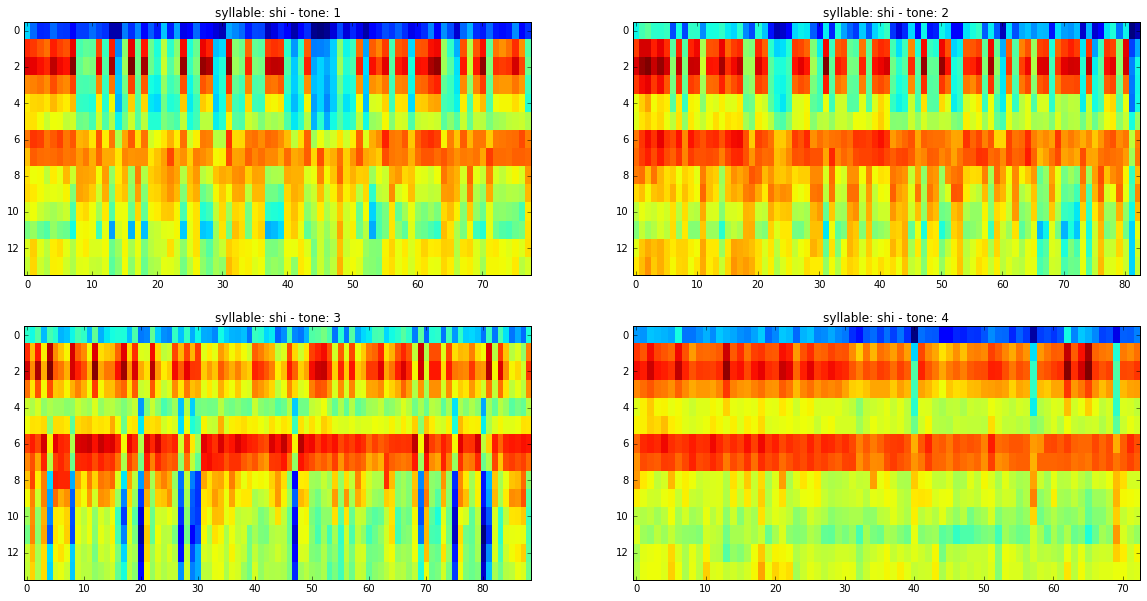

In [841]:
pylab.figure(figsize=(20,10))
pylab.subplot(221)
syllable = 'shi'
for i,(tone,feature_vector) in enumerate(feature_vectors[syllable].items()):
    pylab.subplot(2,2,i+1)
    pylab.imshow(feature_vector[:,:].transpose(), aspect='auto', interpolation='nearest')
    pylab.title("syllable: {} - tone: {}".format(syllable,tone))

Let's train a classifier with that hard-won data!

We will try out a simple ML technique called a support-vector-machine. First, we will do this for a single syllable, **ma**.

In [913]:
syllable = 'ma'

total_samples = 0

for fv in feature_vectors[syllable].values():
    total_samples+=len(fv)
    
print total_samples
X = np.zeros((total_samples,feature_vectors['ma'][1][0].shape[0]))
Y = np.zeros((total_samples,),dtype=np.uint8)

c = 0
for tone, tone_feature_vectors in feature_vectors[syllable].items():
    for tone_feature_vector in tone_feature_vectors:
        X[c,:] = tone_feature_vector
        Y[c] = tone
        c+=1

411


In [914]:
#we randomize the data
indexes = np.arange(len(X))
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

In [915]:
from sklearn.cross_validation import train_test_split
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.33)

In [916]:
from sklearn import svm
clf = svm.SVC()
clf.fit(trainX, trainY)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [917]:
predictY = clf.predict(testX)

In [856]:
import sklearn.metrics as metrics

In [918]:
print "Prediction accuracy: {:.2f}%!".format(metrics.accuracy_score(testY,predictY)*100)

Prediction accuracy: 98.53%!


In [919]:
print metrics.confusion_matrix(testY,predictY)

[[41  0  0  0]
 [ 0 37  2  0]
 [ 0  0 22  0]
 [ 0  0  0 34]]


### Let's increase the difficulty! Instead of recognizing the tone, we also want to recognize the syllable.

In [920]:
total_samples = 0

for syllable in feature_vectors:
    for fv in feature_vectors[syllable].values():
        total_samples+=len(fv)
    
print total_samples
XX = np.zeros((total_samples,feature_vectors['ma'][1][0].shape[0]))
YY = np.zeros((total_samples,),dtype=np.uint8)

#we number the syllables...
syllable_index = {syllable : i for i, syllable in enumerate(feature_vectors)}

print syllable_index

c = 0
for syllable in feature_vectors:
    for tone, tone_feature_vectors in feature_vectors[syllable].items():
        for tone_feature_vector in tone_feature_vectors:
            XX[c,:] = tone_feature_vector
            YY[c] = 4*syllable_index[syllable]+tone
            c+=1

2950
{'zheng': 0, 'ma': 1, 'ba': 2, 'weng': 3, 'bu': 4, 'liang': 5, 'shi': 7, 'tie': 6}


In [921]:
from sklearn.cross_validation import train_test_split
(trainXX, testXX, trainYY, testYY) = train_test_split(XX, YY, test_size = 0.33)

In [948]:
from sklearn import svm
clf = svm.SVC()
clf.fit(trainXX, trainYY)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [949]:
predictYY = clf.predict(testXX)

In [950]:
print "Prediction accuracy: {:.2f}%!".format(metrics.accuracy_score(testYY,predictYY)*100)

Prediction accuracy: 92.51%!


In [951]:
print metrics.confusion_matrix(testYY,predictYY)

[[26  1  0 ...,  0  0  0]
 [ 1 20 11 ...,  0  0  0]
 [ 0  2 32 ...,  0  0  0]
 ..., 
 [ 1  0  0 ..., 23  0  3]
 [ 0  0  0 ...,  0 26  0]
 [ 0  0  0 ...,  4  0 17]]


## Wohoo, it works :)

The system is very limited though and will not work for different speakers or even when using a different absolute pitch. It demonstrates all the basic steps that are necessary in order to build a speech recognition engine.